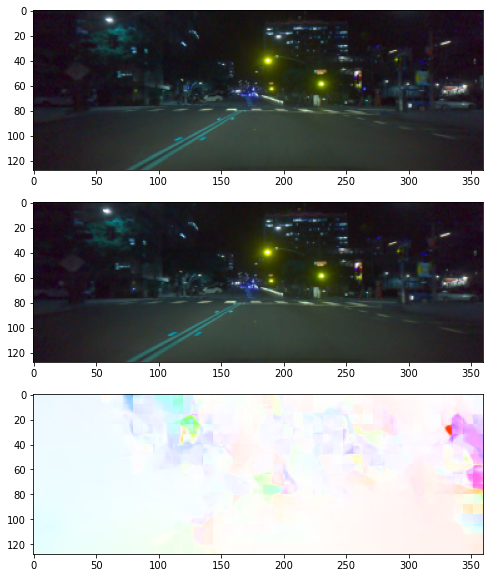

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import generate_frames, process, transform_image
from tqdm import tqdm
from torchvision.models.optical_flow import Raft_Large_Weights, raft_large
from torchvision.utils import flow_to_image
from model import Network

video_path = 'labeled/3.hevc'

device = "cuda" if torch.cuda.is_available() else "cpu"
model_large = raft_large(weights=Raft_Large_Weights.C_T_V2, progress=False).to(device)
model_large.eval()

prev, curr = next(generate_frames(video_path))
with torch.no_grad():
    flow_image = model_large(process(prev).to(device), process(curr).to(device))[-1]
    flow_image = flow_to_image(flow_image).squeeze(0).cpu().permute(1,2,0)
prev, curr = transform_image(prev), transform_image(curr)
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10, 10)
ax[0].imshow(prev)
ax[1].imshow(curr)
ax[2].imshow(flow_image)

In [28]:
import random
import torch.utils.data as data_utils

def train_data(videos_train=[0,1,2,4], flips=False):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model_large = raft_large(weights=Raft_Large_Weights.C_T_V2, progress=False).to(device)
  model_large.eval()
  flip = False
  with torch.no_grad():
    for v in videos_train:
        video_path, txt_path = f'labeled/{v}.hevc', f'labeled/{v}.txt'
        angles = np.loadtxt(txt_path)[1:]
        labels = angles[~np.isnan(angles).any(axis=1)]
        true_t = 0
        for t, (prev,curr) in enumerate(tqdm(generate_frames(video_path))):
            if np.isnan(angles[t]).any():
                continue
            if flips:
              if flip := random.choice([True,False]):
                  labels[true_t][1]*=-1
            prev, curr = process(prev, flip).to(device), process(curr,flip).to(device)
            flow = model_large(prev,curr)[-1]
            if t==0:
                data = flow
            else:
                data = torch.cat([data,flow])
            true_t+=1
        dataset = torch.utils.data.TensorDataset(data, torch.from_numpy(labels).float().to(device))
        torch.save(dataset, f'pts/{v}_train.pt')

def eval_data(videos_eval=[3]):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model_large = raft_large(weights=Raft_Large_Weights.C_T_V2, progress=False).to(device)
  model_large.eval()
  with torch.no_grad():
    for v in videos_eval:
        video_path, txt_path = f'labeled/{v}.hevc', f'labeled/{v}.txt'
        angles = np.loadtxt(txt_path)[1:]
        labels = angles[~np.isnan(angles).any(axis=1)]
        for t, (prev,curr) in enumerate(tqdm(generate_frames(video_path))):
            if np.isnan(angles[t]).any():
                continue
            prev, curr = process(prev).to(device), process(curr).to(device)
            flow = model_large(prev,curr)[-1]
            if t==0:
                data = flow
            else:
                data = torch.cat([data,flow])
        dataset = torch.utils.data.TensorDataset(data, torch.from_numpy(labels).float().to(device))
        torch.save(dataset, f'pts/{v}_eval.pt')

def train_eval_datasets(train_ids=[0,1,2,4], eval_ids=[3]):
  for v in train_ids:
      datasets.append(torch.load(f'pts/{v}_train.pt'))
  train_d = torch.utils.data.ConcatDataset(datasets)

  datasets = []
  for v in eval_ids:
      datasets.append(torch.load(f'pts/{v}_eval.pt'))
  eval_d = torch.utils.data.ConcatDataset(datasets)
  return train_d, eval_d

train_data()
eval_data()

FileNotFoundError: 0.txt not found.

In [4]:
train_d, eval_d = train_eval_datasets()

In [51]:
from torch.utils.data import DataLoader

EPOCHS = 20
train_loader = DataLoader(train_d, batch_size=32, num_workers=0, shuffle=True, pin_memory=False)
eval_loader = DataLoader(eval_d, batch_size=1, num_workers=0, shuffle=False, pin_memory=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {}
config['input_shape'] = (1, 2, 360, 128)
config['n_classes'] = 2
config['base_channels'] = 16
config['block_type'] = 'basic'
config['depth'] = 98

model = Network(config).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2,
    patience=1, threshold=0.01, threshold_mode='abs', min_lr=3e-8)
train_history = []
eval_history = []

print('Start training ...')
min_ev = 10000
for epoch in range(EPOCHS):
    model.train()
    training_loss = 0
    eval_loss = 0
    for i, (flow, angle) in enumerate(train_loader):
        flow, angle = flow.to(device), angle.to(device)
        optimizer.zero_grad()
        pred_angle = model(flow)
        loss = criterion(pred_angle, angle)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_history.append(training_loss/len(train_loader))
    
    model.eval()
    #torch.save(model.state_dict(), f'model_epoch_{epoch}.pt')
    with torch.no_grad():
        for i, (flow, angle) in enumerate(eval_loader):
            flow, angle = flow.to(device), angle.to(device)
            with torch.no_grad():
                pred_angle = model(flow)
                loss = criterion(pred_angle, angle)
                eval_loss += loss.item()
        if eval_loss/len(eval_loader) < min_ev:
            min_ev = eval_loss/len(eval_loader)
            torch.save(model.state_dict(), 'least_eval_loss.pt')
        eval_history.append(eval_loss/len(eval_loader))
        logging_dict = {"epoch": epoch+1,
                        "train_epoch_loss": training_loss/len(train_loader),
                        "eval_epoch_loss": eval_loss/len(eval_loader),
                        "lr": optimizer.param_groups[0]['lr']}
        print (logging_dict)
        scheduler.step(training_loss/len(train_loader))

print('Training complete!')
torch.save(model.state_dict(), 'model.pt')
print('Model saved!')

Start training ...


OutOfMemoryError: ignored

In [43]:
from utils import m_a, get_error

model.load_state_dict(torch.load('least_eval_loss.pt'))
model.eval()
preds, gt = [], []
for i, (flow, angle) in enumerate(eval_loader):
        flow, angle = flow.to(device), angle.to(device)
        gt.append(angle.cpu().numpy()[0])
        with torch.no_grad():
            pred_angle = model(flow)
            preds.append(pred_angle.cpu().numpy()[0]) 

preds, gt = np.array(preds), np.array(gt)
get_error(preds, gt, 10)
plt.plot(m_a(preds[:,0],10))
plt.plot(gt[:,0])

In [ ]:
plt.plot(m_a(preds[:,1],10))
plt.plot(gt[:,1])